### build RNN from scratch

#### repair the dataset

In [334]:
# import the required packages
import time 
import math 
import numpy as np 
import matplotlib.pyplot as plt

In [335]:
# hyperparameters
learning_rate =  1e-4
T = 50 # sequence length
epochs = 10
hidden_dim = 100
output_dim = 1
bptt_truncate = 3
min_clip_val = -10
max_clip_val = 10

In [336]:
# activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def softmax(x):
    xt = np.exp(x - np.max(x))
    return xt / np.sum(xt)

sin_wave (200,)


Text(0.5, 1.0, 'full dataset')

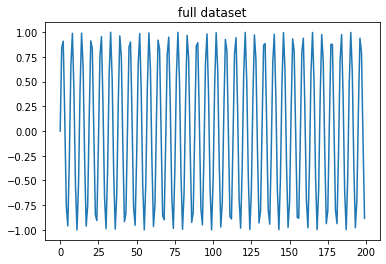

In [337]:
# repair dataset
sin_wave = np.array([math.sin(x) for x in range(200)])
print(f'sin_wave {sin_wave.shape}')
plt.plot(sin_wave)
plt.title('full dataset')

X (100, 50, 1)
Y (100, 1)


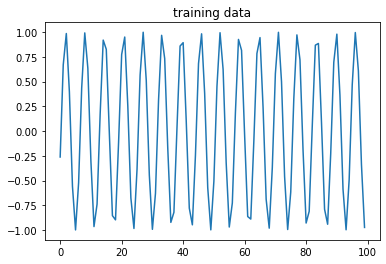

In [338]:
# training data
X = [] 
Y = []
num_records = len(sin_wave) - T # the first 150 element will be take for training data, the next 50 element will be for validation

# X entries are 50 data points
# Y entries are the 51 data points
for i in range(num_records - T):
    X.append(sin_wave[i:i+T])
    Y.append(sin_wave[i+T])

plt.plot(Y)
plt.title('training data')

# convert to numpy array
X = np.array(X)
Y = np.array(Y)

# reshape
X = np.expand_dims(X,2)
print(f'X {X.shape}')
Y = np.expand_dims(Y,1)
print(f'Y {Y.shape}')

X_val (50, 50, 1)
Y_val (50, 1)


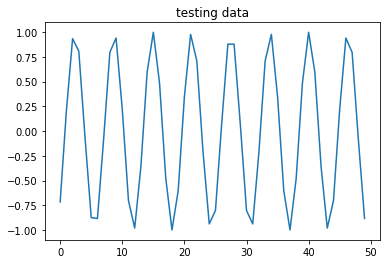

In [339]:
# training data
X_val = [] 
Y_val = []

for i in range(num_records-T,num_records):
    X_val.append(sin_wave[i:i+T])
    Y_val.append(sin_wave[i+T])

plt.plot(Y_val)
plt.title('testing data')

# convert to numpy array
X_val = np.array(X_val)
Y_val = np.array(Y_val)

# reshape
X_val = np.expand_dims(X_val,2)
print(f'X_val {X_val.shape}')
Y_val = np.expand_dims(Y_val,1)
print(f'Y_val {Y_val.shape}')

X (100, 50, 1)
Y (100, 1)
X_val (50, 50, 1)
Y_val (50, 1)


Text(0.5, 1.0, 'full dataset')

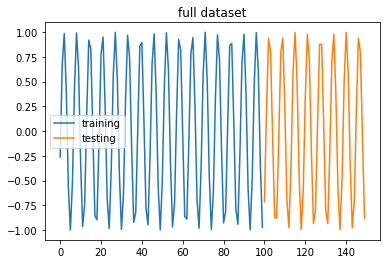

In [340]:
# plot training and validation dataset
print(f'X {X.shape}')
print(f'Y {Y.shape}')
print(f'X_val {X_val.shape}')
print(f'Y_val {Y_val.shape}')
plt.plot(range(len(X)),Y,label = 'training')
plt.plot(range(len(X),len(X)+ len(X_val)),Y_val,label = 'testing')
plt.legend(loc = 'best')
plt.title('full dataset')

#### Victor Zhou implementation

- `U` is the weight matrix for weights between input and hidden layers

- `V` is the weight matrix for weights between hidden and ouput layers

- `W` is the weight matrix for shared weights in the RNN layer (hidden layer)

In [341]:
from numpy.random import rand

In [342]:
# initialize U,W,V matrix
U = rand(hidden_dim,T)
V = rand(output_dim,hidden_dim)
W = rand(hidden_dim,hidden_dim)
bh = rand(hidden_dim,1)
by = rand(output_dim,1)

print(f'U {U.shape}')
print(f'V {V.shape}')
print(f'W {W.shape}')
print(f'bh {bh.shape}')
print(f'by {by.shape}')
print(f'X {X.shape}')
print(f'Y {Y.shape}')
print(f'X_val {X_val.shape}')
print(f'Y_val {Y_val.shape}')

U (100, 50)
V (1, 100)
W (100, 100)
bh (100, 1)
by (1, 1)
X (100, 50, 1)
Y (100, 1)
X_val (50, 50, 1)
Y_val (50, 1)


In [343]:
# forward propagation
def forward_pass(x,y,U,V,W):
    layers = []
    prev_h = np.zeros((hidden_dim,1))
    for t in range(T):
        new_input =  np.zeros(x.shape)
        new_input[t] = x[t]
        z = U @ x + W @ prev_h + bh
        h = tanh(z)
        y_hat = V @ h + by # the last y_hat is your prediction
        # storage h and previous h
        layers.append({'prev_h':prev_h,'h':h})
        # update previous h
        prev_h = h
    return layers,y_hat

x,y = X[0],Y[0]

layers,y_hat = forward_pass(x,y,U,V,W)

print(f'layers lenght {len(layers)}')
print(f'y_hat {y_hat}')

layers lenght 50
y_hat [[50.12682851]]


In [344]:
def calc_loss(X,Y,U,V,W):
    loss = 0.0
    for i in range(Y.shape[0]):
        x,y = X[i],Y[i]
        layers,y_hat = forward_pass(x,y,U,V,W)
        loss += (y-y_hat)**2/2
    return np.float(loss)

calc_loss(X,Y,U,V,W)

125636.34410071415

In [353]:
def backprop(x,y,U,V,W,layers,y_hat):
    
    # differentials at current prediction
    dU = np.zeros(U.shape)
    dW = np.zeros(W.shape)
    dV = np.zeros(V.shape)
    d_bh = np.zeros(bh.shape)
    d_by = np.zeros(by.shape)
    
    # differentials at current timestep
    seq_len = x.shape[0] # equal T
    
    # calc dl/dy
    d_y = y - y_hat # (1,1)
    
    # calc dV only the last timestep impact to V
    dV = d_y @ layers[-1]['h'].T
    
    # calc dL/dh = dL/dy * dy/dh
    d_h = V.T @ d_y # (100,1)
    
    d_t = d_h * (1 - layers[-1]['h']**2) 
    
    for t in reversed(range(T)):
        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        
        temp = ((1- layers[t]['h']**2)*d_h)
        
        dU += temp @ new_input.T
        
        dW += temp @ layers[t]['prev_h'].T
        
        #d_t = W.T @ d_t * (1-layers[t]['prev_h']**2) 
        
    return dU,dW,dV

layers,y_hat = forward_pass(x,y,U,V,W)

dU,dW,dV = backprop(x,y,U,V,W,layers,y_hat)

Epoch: 0 Loss: 125554.48173770058, Validation Loss: 62775.268366013195
Epoch: 1 Loss: 16837.619128911298, Validation Loss: 8418.062610791094
Epoch: 2 Loss: 2275.3946748159588, Validation Loss: 1137.3989743763852
Epoch: 3 Loss: 325.6796091289847, Validation Loss: 162.70564021255396
Epoch: 4 Loss: 64.94315514906042, Validation Loss: 32.397515249740174
Epoch: 5 Loss: 30.187565121205967, Validation Loss: 15.041719521525337
Epoch: 6 Loss: 25.596101299701306, Validation Loss: 12.75404006082864
Epoch: 7 Loss: 25.00475942625831, Validation Loss: 12.461316581254001
Epoch: 8 Loss: 24.934250874797886, Validation Loss: 12.427141170164049
Epoch: 9 Loss: 24.92799568600311, Validation Loss: 12.424408475116863
Epoch: 10 Loss: 24.928325818845824, Validation Loss: 12.424718087471938
Epoch: 11 Loss: 24.92879764928521, Validation Loss: 12.425006911178157
Epoch: 12 Loss: 24.9290173801647, Validation Loss: 12.42513614283511
Epoch: 13 Loss: 24.929104109258144, Validation Loss: 12.425186596043664
Epoch: 14 Lo

Text(0.5, 1.0, 'loss-curve')

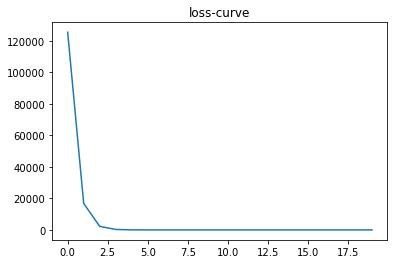

In [354]:
def train(X,Y,X_val,Y_val,U,W,V):
    losses = []
    # train
    for epoch in range(epochs):
        #calc loss
        loss = calc_loss(X,Y,U,V,W)
        losses.append(loss)
        loss_val = calc_loss(X_val,Y_val,U,V,W)
        print(f'Epoch: {epoch} Loss: {loss}, Validation Loss: {loss_val}')
        # loop over each label
        for i in range(Y.shape[0]):
            x,y = X[i],Y[i]
            # forward
            layers,y_hat = forward_pass(x,y,U,V,W)
            # backward
            dU,dW,dV = backprop(x,y,U,V,W,layers,y_hat)
            # SGD
            U += learning_rate * dU
            W += learning_rate * dW
            V += learning_rate * dV
    
    return U,W,V,losses

# set hyperparameter
epochs = 20
bptt_truncate = 5
min_clip_val = -20
max_clip_val = 20
            
# init U,W,V
U,W,V = initialize_matrices(T,hidden_dim,output_dim)
# train
U,W,V,losses = train(X,Y,X_val,Y_val,U,W,V)

plt.plot(losses)
plt.title('loss-curve')

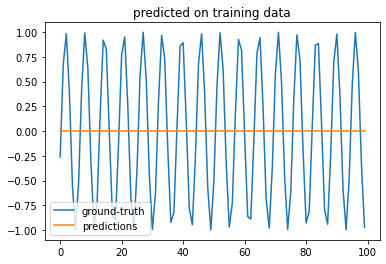

In [355]:
predictions = []
for i in range(Y.shape[0]):
    x,y = X[i],Y[i]
    layers,y_hat = forward_pass(x,y,U,V,W)
    predictions.append(y_hat)

# turn it into numpy array
predictions = np.array(predictions)
plt.plot(Y,label = 'ground-truth')
plt.plot(np.ravel(predictions),label = 'predictions')
plt.legend()
plt.title('predicted on training data')
plt.show()

####  Huiming Song implementation without bias

In [253]:
# initialize matrix
def initialize_matrices(T,hidden_dim,output_dim):
    np.random.seed(3454)
    U = np.random.uniform(0,1,(hidden_dim,T)) # weights between input layer and hidden layer
    V = np.random.uniform(0,1,(output_dim,hidden_dim)) # weights between hidden layer and output layer
    W = np.random.uniform(0,1,(hidden_dim,hidden_dim)) # recurrent weights between each timestep layer (RNN weights)
    return U,W,V

U,W,V = initialize_matrices(T,hidden_dim,output_dim)

print(f'U {U.shape}')
print(f'V {V.shape}')
print(f'W {W.shape}')

U (100, 50)
V (1, 100)
W (100, 100)


In [255]:
# forward function
x,y = X[0],Y[0]

def forward_pass(x,y,U,V,W):
    layers = []
    prev_h = np.zeros((hidden_dim,1))
    for t in range(T):
        new_input = np.zeros(x.shape) # (T,1)
        new_input[t] = x[t]
        z = U @ x + W @ prev_h
        h = tanh(z) # (hidden_dim,T)x(T,1) + (hidden_dim,hidden_dim)x(hidden_dim,1)
        y_hat = o = V @ h # (1,hidden_dim)x(hidden_dim,1)
        layers.append({"prev_h":prev_h,"h":h})
        prev_h = h
    return layers,y_hat

layers,y_hat = forward_pass(x,y,U,V,W)

In [256]:
# calculate the loss
def calc_loss(X,Y,U,V,W):
    loss = 0.0
    for i in range(Y.shape[0]):
        x,y = X[i],Y[i]
        _,y_hat = forward_pass(x,y,U,V,W)
        loss += (y - y_hat)**2/2 #mean square error
    return np.float(loss)

loss = calc_loss(X,Y,U,V,W)
loss_val = calc_loss(X,Y,U,V,W)
print(f'Loss: {loss}, Validation Loss: {loss_val}')

Loss: 123018.72740117362, Validation Loss: 123018.72740117362


In [257]:
def bptt(x,U,V,W,layers):
    dU = np.zeros(U.shape)
    dW = np.zeros(W.shape)
    dV = np.zeros(V.shape)
    
    dU_t = np.zeros(U.shape)
    dW_t = np.zeros(W.shape)
    dV_t = np.zeros(V.shape)
    
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    
    for t in range(T):
        print(f'timestep: {t}')
        for _ in range(t,max(-1,t-bptt_truncate-1),-1): # t-1 or t
            print(f'\tstep: {_}')

bptt(x,U,V,W,layers)

timestep: 0
	step: 0
timestep: 1
	step: 1
	step: 0
timestep: 2
	step: 2
	step: 1
	step: 0
timestep: 3
	step: 3
	step: 2
	step: 1
	step: 0
timestep: 4
	step: 4
	step: 3
	step: 2
	step: 1
timestep: 5
	step: 5
	step: 4
	step: 3
	step: 2
timestep: 6
	step: 6
	step: 5
	step: 4
	step: 3
timestep: 7
	step: 7
	step: 6
	step: 5
	step: 4
timestep: 8
	step: 8
	step: 7
	step: 6
	step: 5
timestep: 9
	step: 9
	step: 8
	step: 7
	step: 6
timestep: 10
	step: 10
	step: 9
	step: 8
	step: 7
timestep: 11
	step: 11
	step: 10
	step: 9
	step: 8
timestep: 12
	step: 12
	step: 11
	step: 10
	step: 9
timestep: 13
	step: 13
	step: 12
	step: 11
	step: 10
timestep: 14
	step: 14
	step: 13
	step: 12
	step: 11
timestep: 15
	step: 15
	step: 14
	step: 13
	step: 12
timestep: 16
	step: 16
	step: 15
	step: 14
	step: 13
timestep: 17
	step: 17
	step: 16
	step: 15
	step: 14
timestep: 18
	step: 18
	step: 17
	step: 16
	step: 15
timestep: 19
	step: 19
	step: 18
	step: 17
	step: 16
timestep: 20
	step: 20
	step: 19
	step: 18
	step: 

In [258]:
#layers[5]['h'] == layers[6]['prev_h']

In [259]:
def my_bptt(x,y,U,V,W,layers,y_hat):
    
    # differentials at current prediction
    dU = np.zeros(U.shape)
    dW = np.zeros(W.shape)
    dV = np.zeros(V.shape)
    
    # differentials each timestep
    dU_t = np.zeros(U.shape)
    dW_t = np.zeros(W.shape)
    dV_t = np.zeros(V.shape)
    
    # differentials each backpropagation truncate
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    
    #dL/dy
    dmulv = y - y_hat # (1,1)
    #dL/dh = dL/dy * dy/dh
    dsv = V.T @ dmulv # (100,1)

    def calc_prev_d(h,d,W):
        d_sum = (1-h**2)*d # activation_function *  
        return W.T @ d_sum # W.T or W ??
    
    for t in range(T):
        
        #print(f'timestep: {t}')
        # differential dLdV each timestep
        dV_t = dmulv @ np.transpose(layers[t]['h']) # (1,1)x(100,1).T
        # term d = (y-y_hat)V
        d_t = dsv * (1 - layers[t]['h']**2) # V.T.(y - y_hat)(1-h^2) (100,1)

        for _ in range(t,max(-1,t-bptt_truncate-1),-1):
            
            new_input  = np.zeros(x.shape)
            new_input[_] = x[_]
            
            dU_i = d_t @ new_input.T
            dW_i = d_t @ layers[_]['prev_h'].T
            
            dU_t += dU_i
            dW_t += dW_i
            
            d_t = calc_prev_d(layers[_]['prev_h'],d_t,W)
            #print(f'\tstep: {_}')
                
        # accumulate differentials each timestep
        dV += dV_t
        dU += dU_t
        dW += dW_t
        
        # take care of possible exploding gradients
        if dU.max() > max_clip_val:
            dU[dU > max_clip_val] = max_clip_val
        if dV.max() > max_clip_val:
            dV[dV > max_clip_val] = max_clip_val
        if dW.max() > max_clip_val:
            dW[dW > max_clip_val] = max_clip_val
        
        if dU.min() < min_clip_val:
            dU[dU < min_clip_val] = min_clip_val
        if dV.min() < min_clip_val:
            dV[dV < min_clip_val] = min_clip_val
        if dW.min() < min_clip_val:
            dW[dW < min_clip_val] = min_clip_val
    
    return dU,dV,dW

bptt_truncate = 3

x,y = X[0],Y[0]

layers,y_hat = forward_pass(x,y,U,V,W)

dU,dV,dW = my_bptt(x,y,U,V,W,layers,y_hat)

Epoch: 0 Loss: 123018.72740117362, Validation Loss: 61470.18100935633
Epoch: 1 Loss: 77842.84922945879, Validation Loss: 38893.50384271165
Epoch: 2 Loss: 42154.66483462374, Validation Loss: 20919.313299252208
Epoch: 3 Loss: 18011.29691984756, Validation Loss: 8904.677947775313
Epoch: 4 Loss: 4163.93085233243, Validation Loss: 2046.5989097509519
Epoch: 5 Loss: 33.40591951069156, Validation Loss: 16.42355941497501
Epoch: 6 Loss: 4.590584911067157, Validation Loss: 2.405859068295019
Epoch: 7 Loss: 4.794085337906487, Validation Loss: 2.5753924888728754
Epoch: 8 Loss: 4.5905790582568, Validation Loss: 2.4058402659371265
Epoch: 9 Loss: 4.590581063608095, Validation Loss: 2.4058468495947634


Text(0.5, 1.0, 'loss-curve')

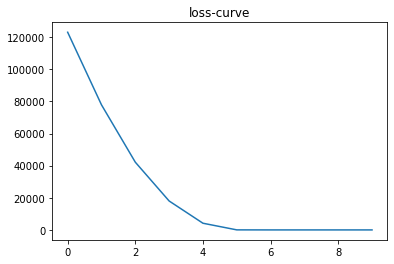

In [260]:
def train(X,Y,X_val,Y_val,U,W,V):
    losses = []
    # train
    for epoch in range(epochs):
        #calc loss
        loss = calc_loss(X,Y,U,V,W)
        losses.append(loss)
        loss_val = calc_loss(X_val,Y_val,U,V,W)
        print(f'Epoch: {epoch} Loss: {loss}, Validation Loss: {loss_val}')
        # loop over each label
        for i in range(Y.shape[0]):
            x,y = X[i],Y[i]
            # forward
            layers,y_hat = forward_pass(x,y,U,V,W)
            # backward
            dU,dV,dW = my_bptt(x,y,U,V,W,layers,y_hat)
            # SGD
            U += learning_rate * dU
            W += learning_rate * dW
            V += learning_rate * dV
    
    return U,W,V,losses

# set hyperparameter
epochs = 10
bptt_truncate = 5
min_clip_val = -10
max_clip_val = 10
            
# init U,W,V
U,W,V = initialize_matrices(T,hidden_dim,output_dim)
# train
U,W,V,losses = train(X,Y,X_val,Y_val,U,W,V)

plt.plot(losses)
plt.title('loss-curve')

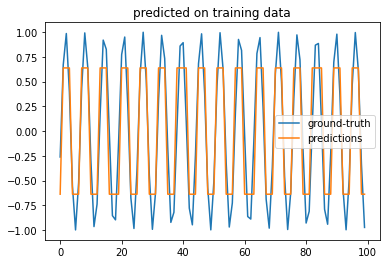

In [261]:
predictions = []
for i in range(Y.shape[0]):
    x,y = X[i],Y[i]
    layers,y_hat = forward_pass(x,y,U,V,W)
    predictions.append(y_hat)

# turn it into numpy array
predictions = np.array(predictions)
plt.plot(Y,label = 'ground-truth')
plt.plot(np.ravel(predictions),label = 'predictions')
plt.legend()
plt.title('predicted on training data')
plt.show()

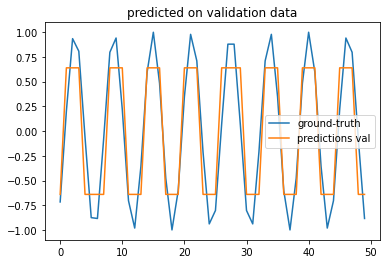

In [263]:
predictions_val = []
for i in range(Y_val.shape[0]):
    x_val,y_val = X_val[i],Y_val[i]
    layers,y_hat = forward_pass(x_val,y_val,U,V,W)
    predictions_val.append(y_hat)

# turn it into numpy array
predictions_val = np.array(predictions_val)
plt.plot(Y_val,label = 'ground-truth')
plt.plot(np.ravel(predictions_val),label = 'predictions val')
plt.legend()
plt.title('predicted on validation data')
plt.show()

#### other sequence wave

200


Text(0.5, 1.0, '')

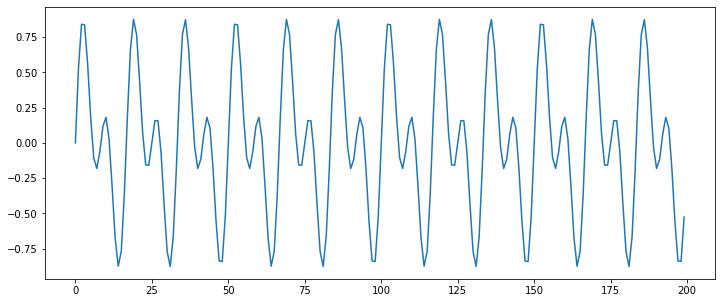

In [264]:
f = 30
seq_wave = np.array([(0.5 * math.sin(1*f*2*np.pi*x) + 0.5 * math.sin(2*f*2*np.pi*x)) for x in np.arange(0,0.4,0.002)])
print(len(seq_wave))
# visualize the seq wave
fig = plt.figure(figsize = (12.,5.))
plt.plot(seq_wave)
plt.title('')

In [265]:
# training dataset
X = []
Y = []
seq_len = 50
num_records = len(seq_wave) - seq_len
print(f'seq_len: {seq_len}')
print(f'num_records: {num_records}')
for i in range(num_records- 50):
    X.append(seq_wave[i:i+seq_len])
    Y.append(seq_wave[i+seq_len])
X = np.array(X)
Y = np.array(Y)
print(f'X.shape before: {X.shape}')
print(f'Y.shape before: {Y.shape}')
X = np.expand_dims(X,axis = 2)
Y = np.expand_dims(Y,axis =1 )
print(f'X.shape after: {X.shape}')
print(f'Y.shape after: {Y.shape}')

seq_len: 50
num_records: 150
X.shape before: (100, 50)
Y.shape before: (100,)
X.shape after: (100, 50, 1)
Y.shape after: (100, 1)


In [266]:
# validation dataset
X_val = []
Y_val = []
seq_len = 50

for i in range(num_records- 50,num_records):
    X_val.append(seq_wave[i:i+seq_len])
    Y_val.append(seq_wave[i+seq_len])
X_val = np.array(X_val)
Y_val = np.array(Y_val)
print(f'X_val.shape before: {X_val.shape}')
print(f'Y_val.shape before: {Y_val.shape}')
X_val = np.expand_dims(X_val,axis = 2)
Y_val = np.expand_dims(Y_val,axis =1 )
print(f'X_val.shape after: {X_val.shape}')
print(f'Y_val.shape after: {Y_val.shape}')

X_val.shape before: (50, 50)
Y_val.shape before: (50,)
X_val.shape after: (50, 50, 1)
Y_val.shape after: (50, 1)


Text(0.5, 1.0, 'full data')

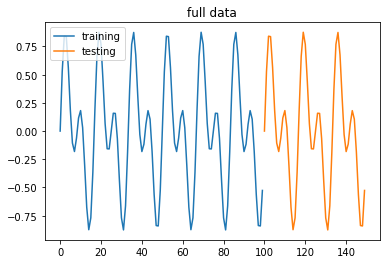

In [267]:
# display full dataset
plt.plot(range(len(X)),Y,label = 'training')
plt.plot(range(len(X),len(X)+len(X_val)),Y_val,label = 'testing')
plt.legend()
plt.title("full data")

In [268]:
# set hyperparameter
epochs = 10
bptt_truncate = 10
min_clip_val = -10
max_clip_val = 10
            
# init U,W,V
U,W,V = initialize_matrices(T,hidden_dim,output_dim)
# train
U,W,V,losses = train(X,Y,X_val,Y_val,U,W,V)

Epoch: 0 Loss: 121889.12628883393, Validation Loss: 60944.563144416956
Epoch: 1 Loss: 77517.64416065326, Validation Loss: 38758.82208032662
Epoch: 2 Loss: 43087.66792999618, Validation Loss: 21543.833964998088
Epoch: 3 Loss: 18625.810523724518, Validation Loss: 9312.905261862257
Epoch: 4 Loss: 4348.102363166344, Validation Loss: 2174.051181583171
Epoch: 5 Loss: 12.999668419952515, Validation Loss: 6.499834209976255
Epoch: 6 Loss: 11.911192934671295, Validation Loss: 5.95559646733566
Epoch: 7 Loss: 12.002087912127813, Validation Loss: 6.001043956063923
Epoch: 8 Loss: 12.005506743462455, Validation Loss: 6.002753371731238
Epoch: 9 Loss: 12.006064015952553, Validation Loss: 6.003032007976296


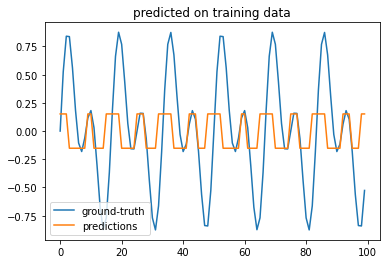

In [271]:
predictions = []
for i in range(Y.shape[0]):
    x,y = X[i],Y[i]
    layers,y_hat = forward_pass(x,y,U,V,W)
    predictions.append(y_hat)

# turn it into numpy array
predictions = np.array(predictions)
plt.plot(Y,label = 'ground-truth')
plt.plot(np.ravel(predictions),label = 'predictions')
plt.legend()
plt.title('predicted on training data')
plt.show()

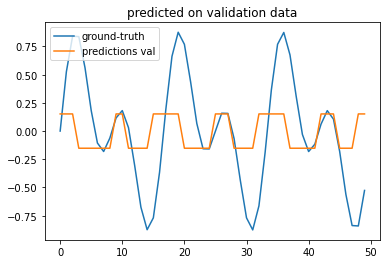

In [273]:
predictions_val = []
for i in range(Y_val.shape[0]):
    x_val,y_val = X_val[i],Y_val[i]
    layers,y_hat = forward_pass(x_val,y_val,U,V,W)
    predictions_val.append(y_hat)

# turn it into numpy array
predictions_val = np.array(predictions_val)
plt.plot(Y_val,label = 'ground-truth')
plt.plot(np.ravel(predictions_val),label = 'predictions val')
plt.legend()
plt.title('predicted on validation data')
plt.show()

####  Huiming Song implementation with bias

### references

https://github.com/ytang07/nn_examples/blob/main/rnn/simple_rnn.py

https://songhuiming.github.io/pages/2017/08/20/build-recurrent-neural-network-from-scratch/

https://github.com/vzhou842/rnn-from-scratch
